# 분류 문제

이번 수업에서는 분류 문제를 해결하는 대표적 알고리즘인 로지스틱 회귀, 트리 그리고 SVM 에 대해 알아보겠습니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 분류 분석 개요

본 챕터에서는 간단한 KNN 알고리즘을 이용해서 분류 문제를 학습하고 모델을 평가하는 방법에 대해 알아보겠습니다.       
먼저 분류 문제에서 주로 쓰이는 평가 지표는 다음 Confusion matrix입니다.   

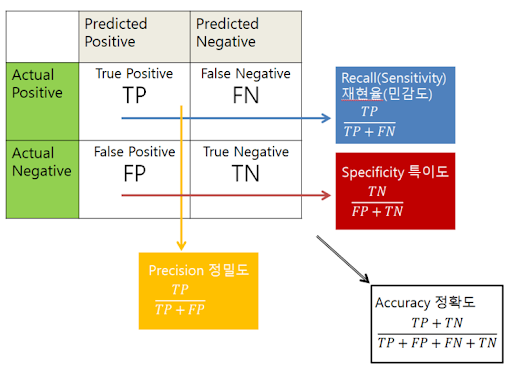

In [3]:
from IPython.display import Image
Image("./confusion matrix.png")

정확도(accuracy)만 평가 지표로 사용할 수 없는 이유는 모든 class에 대해 동일한 예측 성능을 기대할 수 없기 때문입니다.      
예를 들어서, 100개 의 제품 중 1개의 제품만 불량인 경우     

> "모든 제품이 양품이다"     

라고 주장하는 간단한 모델도 99%의 정확도를 달성합니다.     
따라서 각 class 별로 모델의 성능을 평가하는 지표가 필요해서 Confusion matrix를 사용합니다.

### KNN 복습

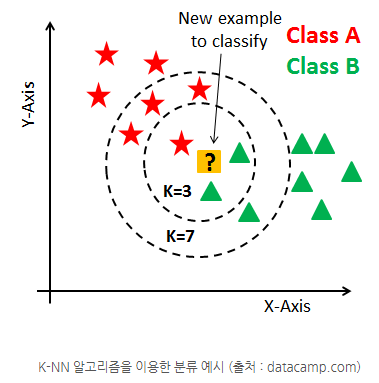

In [5]:
from IPython.display import Image
Image("./KNN.png")

KNN 분류 알고리즘은 New example "주변에 많은" class 로 New example을 분류합니다.

### 실습: KNN을 사용한 분류 모델링 이해 

분류 데이터로는 titanic 데이터를 사용하겠습니다.

In [9]:
titanic = pd.read_csv('Titanic.csv', engine = 'python')
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


titanic 데이터는 타이타닉 사고에서 passenger 의 정보와 생사 여부 (Survival)를 담고 있습니다.     
본 챕터에서는 Survival을 KNN으로 예측하고 이를 평가해보겠습니다.

### 데이터 이해 및 전처리

In [10]:
# 데이터 이해
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  889 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.7+ KB


In [11]:
# 명목형 변수인 승선 위치 (Embarked)의 클래스를 알아봅니다.
titanic['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [12]:
# 모델링을 하기 위해서는 numeric 변수가 필요하기 때문에
# 성별('Sex')와 승선위치('Embarked')에 one-hot encoding을 사용하겠습니다.
# 이 때 두 가지 방법을 사용할 수 있습니다.

# 1. pd.get_dummies 와 pd.concat 사용
# 2. pd.DataFrame.map() 사용

#### 1. pd.get_dummies 와 pd.concat 사용

In [14]:
# 1. pd.get_dummies 와 pd.concat 사용
# 두 가지 방법을 모두 소개하기 위해 데이터는 카피된 데이터를 사용하겠습니다.
data = titanic.copy()

# category data와 numeric data 분리
data_cat, data_num = data[['Sex','Embarked']], data[data.columns.drop(['Sex','Embarked'])]
data_cat.head(2)

,Sex,Embarked
0,male,S
1,female,C


In [18]:
# category data --> numeric data
# pd.get_dummies 사용
dummies = pd.get_dummies(data_cat, drop_first=True)

In [20]:
# numeric으로 변경한 카테고리 변수와 numeric 변수를 합침
# pd.concat 사용
data_concat =  pd.concat([dummies, data_num], axis=1)
data_concat.head()

,Sex_male,Embarked_Q,Embarked_S,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,0,1,3,22.0,1,0,7.2500,0
1,0,0,0,1,38.0,1,0,71.2833,1
2,0,0,1,3,26.0,0,0,7.9250,1
3,0,0,1,1,35.0,1,0,53.1000,1
4,1,0,1,3,35.0,0,0,8.0500,0


#### 2. pd.DataFrame.map() 사용

In [21]:
# 2. pd.DataFrame.map() 사용
# 동일하게 one-hot encoding을 하셔도 무방하지만,
# 이번에는 Embarked class S < C < Q 순서로 승객의 생존 확률이 높다 (또는 낮다)는 것을 안다고 가정하고
# 전처리를 하는 것을 보여드리겠습니다.

data = titanic.copy()

# Embarked 의 'S' --> 1, 'C' --> 2, 'Q' --> 3 으로 '맵핑'함. 
# 값이 클수록 생존 확률이 클 (또는 작을) 것.
mapping = {'S':1, 'C':2, 'Q':3}  
mapping2 = {'male':1, 'female':0}

# pd.DataFrame.map(mapping)
data['Embarked'] = data['Embarked'].map(mapping)
data['Sex'] = data['Sex'].map(mapping2)

In [22]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,22.0,1,0,7.2500,1,0
1,1,0,38.0,1,0,71.2833,2,1
2,3,0,26.0,0,0,7.9250,1,1
3,1,0,35.0,1,0,53.1000,1,1
4,3,1,35.0,0,0,8.0500,1,0


이번 실습에서는 위 data를 사용하겠습니다.

#### KNN 모델 학습 및 평가   
KNN을 학습 시킨 후 정확도, 재현율, 정밀도를 구해보겠습니다.

In [23]:
# 독립 변수, 종속 변수 분리
X, y = data.iloc[:, :-1], data.iloc[:, -1:]

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# 모델 선언 및 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# make predictions
y_pred = knn.predict(X)

<ipython-input-26-d3cf27f84c7f>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X, y)


In [27]:
# 모델을 평가해보겠습니다.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('정확도: ', round(accuracy_score(y, y_pred),3))
print('재현율: ', round(recall_score(y, y_pred),3))
print('정밀도:', round(precision_score(y, y_pred),3))
print('F1 Score:', round(f1_score(y, y_pred),3))

정확도:  0.808
재현율:  0.679
정밀도: 0.788
F1 Score: 0.73


In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [29]:
# Confusion matrix
confusion_matrix(y, y_pred)

array([[487,  62],
       [109, 231]], dtype=int64)

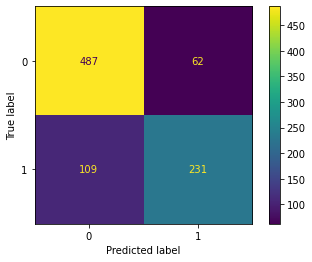

In [30]:
plot_confusion_matrix(knn, X,y)

#### ROC를 구해보겠습니다.

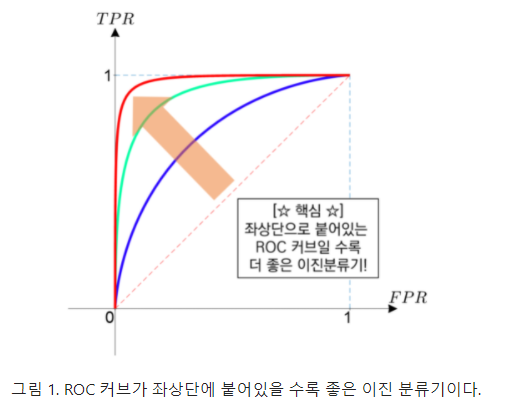

In [36]:
from IPython.display import Image
Image("./roc.png")

ROC 커브는 이진 분류기의 성능을 표현하며, 가능한 모든 threshold에 대해 FPR과 TPR의 비율을 표현합니다.    
최종적으로는 ROC 커브가 왼쪽 상단에 있을 수록 (Area Under Curve -> 1) 일 수록 더 좋은 이진 분류기입니다.

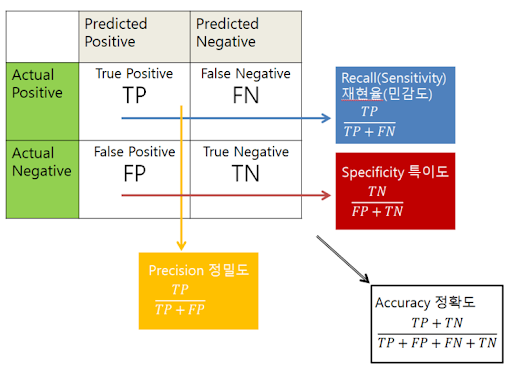

In [44]:
from IPython.display import Image
Image("./confusion matrix.png")

In [32]:
import sklearn.metrics as metrics

In [39]:
# KNN의 output을 확률로써 표현할 수 있음
probs = knn.predict_proba(X)
probs

array([[1. , 0. ],
       [0.4, 0.6],
       [0.4, 0.6],
       ...,
       [0.6, 0.4],
       [0.4, 0.6],
       [1. , 0. ]])

In [41]:
# Survival에 대한 열만 가져옴
preds = probs[:,1]

In [42]:
# ROC의 x축 y축 그리고 threshold를 구해줌.
# fpr (false positive rate): 실제로는 생존하지 못했지만 모델이 생존했다고 예측한 비율
# tpr (true positive rate): 실제로 생존했고 모델이 생존했다고 예측한 비율
# threshold: survival 여부를 판단하는 확률 기준.
## 예를 들어서 threshold가 0.5 라면 
## model probability prediction이 0.5 보다 큰 경우를 survival로 예측함.
fpr, tpr, threshold = metrics.roc_curve(y, preds)

In [43]:
# Area Under the Curve <=1
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.880686810243223

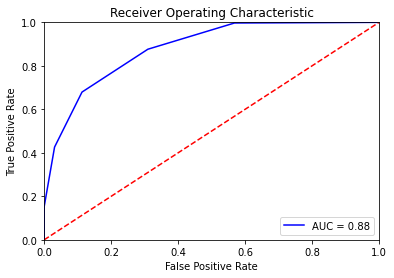

In [34]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 실습: Iris data

In [51]:
# 데이터 불러오기
from sklearn.datasets import load_iris

iris = load_iris()

In [54]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
# target {setosa, versicolor, viginica}를 각각 {0.0, 1.0, 2.0} 으로 매핑
df['target'] = df['target'].map({0:"setosa", 1:"versicolor", 2:"virginica"})
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
# 실습 TODO list
# 위의 df 데이터를 사용합니다.

# (1) X, y 데이터 나누기


# (2) train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적 n_neighbor 구하기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
# n_neighbor 후보: [4,5,6,7,8]
# estimator = KNeighborsClassifier
# GridSearchCV scoring = 'accuracy'를 사용해주세요.

# estimator 선언

# hyper parameter tunning


In [75]:
# (3) 최종 KNN 모델 선언 및 학습
# 위에서 구한 best model을 사용합니다.
# knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용

In [ ]:
# (4) confusion matrix 출력 및 결과 해석


### 실습 가이드 라인

In [78]:
# (1) X, y 데이터 나누기
X, y = df[df.columns.drop('target')], df[['target']]

In [90]:
# (2) train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적 n_neighbor 구하기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
# n_neighbor 후보: [4,5,6,7,8]
# estimator = KNeighborsClassifier
# GridSearchCV scoring = 'accuracy'를 사용해주세요.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_neighbors = [4,5,6,7,8]
grid = {'n_neighbors': n_neighbors}

# estimator 선언
knn = KNeighborsClassifier()

# hyper parameter tunning
gscv = GridSearchCV(knn, grid, scoring= 'accuracy', cv=cv, n_jobs=-1)
results = gscv.fit(X_train, y_train)
print(results.best_params_)

{'n_neighbors': 8}


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [91]:
# cv_results_ 에서 split 결과 확인 가능.
gscv.cv_results_

{'mean_fit_time': array([0.0045489 , 0.0054995 , 0.00489646, 0.00356641, 0.00346687]),
 'std_fit_time': array([0.00107333, 0.00178365, 0.00124912, 0.00071599, 0.00061843]),
 'mean_score_time': array([0.00289923, 0.00300014, 0.00286799, 0.00233343, 0.00216676]),
 'std_score_time': array([0.00069969, 0.00057752, 0.00056219, 0.00059667, 0.000522  ]),
 'param_n_neighbors': masked_array(data=[4, 5, 6, 7, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8}],
 'split0_test_score': array([1., 1., 1., 1., 1.]),
 'split1_test_score': array([1., 1., 1., 1., 1.]),
 'split2_test_score': array([0.90909091, 1.        , 1.        , 1.        , 1.        ]),
 'split3_test_score': array([1., 1., 1., 1., 1.]),
 'split4_test_score': array([0.90909091, 0.90909091, 1.        , 1.        , 1.        ]),
 'split5_test_score': array([

In [92]:
# (3) 최종 KNN 모델 선언 및 학습
# 위에서 구한 best model을 사용합니다.
# knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
knn = results.best_estimator_

# (4) confusion matrix 출력 및 결과 해석
y_train_hat = knn.predict(X_train)
y_test_hat = knn.predict(X_test)

In [93]:
# (4) confusion matrix 출력 및 결과 해석
confusion_matrix(y_train, y_train_hat)

array([[34,  0,  0],
       [ 0, 32,  0],
       [ 0,  2, 37]], dtype=int64)

In [94]:
confusion_matrix(y_test_hat, y_test_hat)

array([[16,  0,  0],
       [ 0, 16,  0],
       [ 0,  0, 13]], dtype=int64)

In [64]:
print(f'정확도: {accuracy_score(y, y_hat):.2f}')

정확도: 0.97


---

## 로지스틱 회귀 (Logistic regression)

In [95]:
from sklearn.linear_model import LogisticRegression

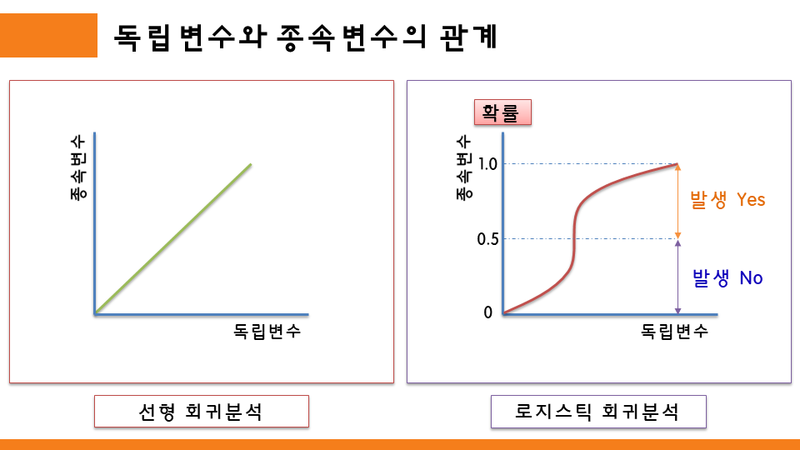

In [97]:
Image("./logistic regression.png")

로지스틱 회귀는 다음을 가정합니다.    
> $Pr(Y=1|X=x) = \frac{exp(x^T\beta)}{1+exp(x^T\beta)}$   

Motivation은 다음과 같습니다.    
> Motivation 1: Linear model $Pr(Y=1|X=x) = x^T\beta$ 는 $x^T\beta \in [0,1]$ 조건에 위배됩니다.   
Motivation 2: Logistic function $F(x)=e^x/(1+e^x)$ 는 항상 구간 $[0,1]$ 에 있습니다.  
Motivation 3: Decision boundary로부터 로지스틱 회귀 모형이 유도됩니다.    


> Decision boundary로 부터 로지스틱 회귀 모형 유도:     
Consider the decision boundary, $\left\{  x: log \frac{Pr(Y=1|X)}{Pr(Y=0|X)} \right\} =0 $    
Suppose that this decision boundary is linear e.g.     


>   
\begin{align*}
log \frac{Pr(Y=1|X)}{Pr(Y=0|X)} &= x^T\beta      \\ \\
    \frac{Pr(Y=1|X)}{Pr(Y=0|X)} &= exp(x^T\beta) \\ \\  
    \frac{Pr(Y=1|X)}{1-Pr(Y=1|X)} &= exp(x^T\beta) \\ \\  
    Pr(Y=1|X) &= exp(x^T\beta)\times (1-Pr(Y=1|X))   \\  
    \therefore Pr(Y=1|X) &= \frac{exp(x^T\beta)}{1+exp(x^T\beta)}   
    \end{align*}

In [98]:
# help(LogisticRegression)

본 챕터에서는 로지스틱 회귀를 python library를 사용해서 실습해보겠습니다. 데이터는 KNN에서 사용한 titanic 데이터를 그대로 사용하도록 하겠습니다.

In [107]:
data = titanic.copy()

# Embarked 의 'S' --> 1, 'C' --> 2, 'Q' --> 3 으로 '맵핑'함. 
# 값이 클수록 생존 확률이 클 (또는 작을) 것.
mapping = {'S':1, 'C':2, 'Q':3}  
mapping2 = {'male':1, 'female':0}

# pd.DataFrame.map(mapping)
data['Embarked'] = data['Embarked'].map(mapping)
data['Sex'] = data['Sex'].map(mapping2)

In [108]:
# 종속 변수, 독립 변수 나누기
X, y = data[data.columns.drop('Survived')], data[['Survived']]

In [109]:
# train-test split
# hyper parameter를 최적화할 필요는 없기 때문에 Cross validation만을 진행하겠습니다.
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [110]:
# KFold 복습
idx = np.arange(10)
kf2 = KFold(n_splits=5, shuffle=True)
for fold,(idx_train, idx_test) in enumerate(kf2.split(idx)):
    print('fold:',fold)
    print("idx train:",idx_train, "idx test:",idx_test)

fold: 0
idx train: [0 1 3 5 6 7 8 9] idx test: [2 4]
fold: 1
idx train: [0 1 2 4 5 6 7 8] idx test: [3 9]
fold: 2
idx train: [1 2 3 4 5 6 7 9] idx test: [0 8]
fold: 3
idx train: [0 1 2 3 4 6 8 9] idx test: [5 7]
fold: 4
idx train: [0 2 3 4 5 7 8 9] idx test: [1 6]


In [114]:
# Kfold 함수 인자 설정 (5 folds 사용)
n_splits = 5

# model 선언
model = LogisticRegression(penalty= 'none') # default penalty = l2

# performance 저장용
perf = {'accuracy_training':[], 'accuracy_test':[]
        ,'recall_training':[], 'recall_test':[], 
        'precision_train':[],'precision_test':[]}

idx = X.index
folds = KFold(n_splits=n_splits, shuffle= True)

for idx_train, idx_test in folds.split(idx):
    X_train = X.loc[idx_train,:]
    X_test = X.loc[idx_test, :]
    y_train = y.loc[idx_train]
    y_test = y.loc[idx_test]

    model.fit(X_train, y_train)
    # performance 계산
    y_hat_tr = model.predict(X_train)
    y_hat_te = model.predict(X_test)
    
    acc_tr = accuracy_score(y_train, y_hat_tr)
    acc_te = accuracy_score(y_test, y_hat_te)
    
    prec_tr = precision_score(y_train, y_hat_tr)
    prec_te = precision_score(y_test, y_hat_te)
    
    rec_tr = recall_score(y_train, y_hat_tr)
    rec_te = recall_score(y_test, y_hat_te)
    
    
    # performance list에 저장
    perf['accuracy_training'].append(acc_tr)
    perf['accuracy_test'].append(acc_te)
    
    perf['precision_train'].append(prec_tr)
    perf['precision_test'].append(prec_te)
    
    perf['recall_training'].append(rec_tr)
    perf['recall_test'].append(rec_te)

df_perf = pd.DataFrame(perf)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [115]:
df_perf

,accuracy_training,accuracy_test,recall_training,recall_test,precision_train,precision_test
0,0.797468,0.831461,0.690566,0.720000,0.746939,0.857143
1,0.801688,0.808989,0.687732,0.690141,0.764463,0.803279
2,0.805907,0.775281,0.711191,0.730159,0.772549,0.666667
3,0.790436,0.803371,0.717857,0.750000,0.741697,0.692308
4,0.813202,0.762712,0.724907,0.619718,0.767717,0.745763


In [116]:
df_perf.mean(axis= 0)

accuracy_training    0.801740
accuracy_test        0.796363
recall_training      0.706451
recall_test          0.702004
precision_train      0.758673
precision_test       0.753032
dtype: float64

---

## Tree 모형

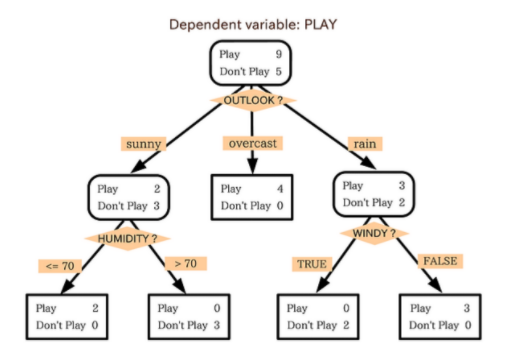

In [117]:
Image("./tree.png")

Decision tree 는 데이터 패턴을 예측 가능한 규칙들의 조합으로 나타냅니다. (Tree 모양)    
질문을 던져서 대상을 좁혀 나가는 '스무고개'와 비슷한 개념입니다.    
위 예시를 참고해주세요.    
만약, 
> Outlook = sunny AND HUMIDITY <= 70 이라면,    
Play 에 해당하는 관측이 2개, Don't Play에 해당하는 관측은 0개이므로,   
새로운 관측이 위 기준을 만족한다면, Play 로 예측을 하게 됩니다.

위 알고리즘을 파이썬 라이브러리를 사용해서 실습해보겠습니다.   

In [121]:
# 데이터 불러오기
data = titanic.copy()

# Embarked 의 'S' --> 1, 'C' --> 2, 'Q' --> 3 으로 '맵핑'함. 
# 값이 클수록 생존 확률이 클 (또는 작을) 것.
mapping = {'S':1, 'C':2, 'Q':3}  
mapping2 = {'male':1, 'female':0}

# pd.DataFrame.map(mapping)
data['Embarked'] = data['Embarked'].map(mapping)
data['Sex'] = data['Sex'].map(mapping2)

# 종속 변수, 독립 변수 나누기
X, y = data[data.columns.drop('Survived')], data[['Survived']]

In [119]:
# 트리 모델 라이브러리는 다음 명령어로 import 합니다.
from sklearn.tree import DecisionTreeClassifier

# 선언하는 방법:
tree = DecisionTreeClassifier() 

In [122]:
# 마찬가지로 K-fold를 사용해서 학습을 해보겠습니다.
# Kfold 함수 인자 설정 (5 folds 사용)
n_splits = 5

# model 선언
model = DecisionTreeClassifier()

# performance 저장용
perf = {'accuracy_training':[], 'accuracy_test':[]
        ,'recall_training':[], 'recall_test':[], 
        'precision_train':[],'precision_test':[]}

idx = X.index
folds = KFold(n_splits=n_splits, shuffle= True)

for idx_train, idx_test in folds.split(idx):
    X_train = X.loc[idx_train,:]
    X_test = X.loc[idx_test, :]
    y_train = y.loc[idx_train]
    y_test = y.loc[idx_test]

    model.fit(X_train, y_train)
    # performance 계산
    y_hat_tr = model.predict(X_train)
    y_hat_te = model.predict(X_test)
    
    acc_tr = accuracy_score(y_train, y_hat_tr)
    acc_te = accuracy_score(y_test, y_hat_te)
    
    prec_tr = precision_score(y_train, y_hat_tr)
    prec_te = precision_score(y_test, y_hat_te)
    
    rec_tr = recall_score(y_train, y_hat_tr)
    rec_te = recall_score(y_test, y_hat_te)
    
    
    # performance list에 저장
    perf['accuracy_training'].append(acc_tr)
    perf['accuracy_test'].append(acc_te)
    
    perf['precision_train'].append(prec_tr)
    perf['precision_test'].append(prec_te)
    
    perf['recall_training'].append(rec_tr)
    perf['recall_test'].append(rec_te)

df_perf = pd.DataFrame(perf)

In [123]:
df_perf

,accuracy_training,accuracy_test,recall_training,recall_test,precision_train,precision_test
0,0.984529,0.769663,0.963370,0.641791,0.996212,0.716667
1,0.984529,0.775281,0.966543,0.760563,0.992366,0.701299
2,0.977496,0.820225,0.946237,0.803279,0.996226,0.710145
3,0.980309,0.780899,0.951673,0.760563,0.996109,0.710526
4,0.985955,0.734463,0.970370,0.671429,0.992424,0.661972


In [124]:
df_perf.mean(axis= 0)

accuracy_training    0.982564
accuracy_test        0.776106
recall_training      0.959639
recall_test          0.727525
precision_train      0.994668
precision_test       0.700122
dtype: float64

training data 와 test data 사이 performance 차이가 큽니다.    
즉, 모델이 훈련 데이터에 과적합 (overfit) 했으므로 모델을 개선할 필요가 있습니다.

Tree 모델에서는, "pruning" (가지치기) 알고리즘을 이용해서 이를 해결합니다.

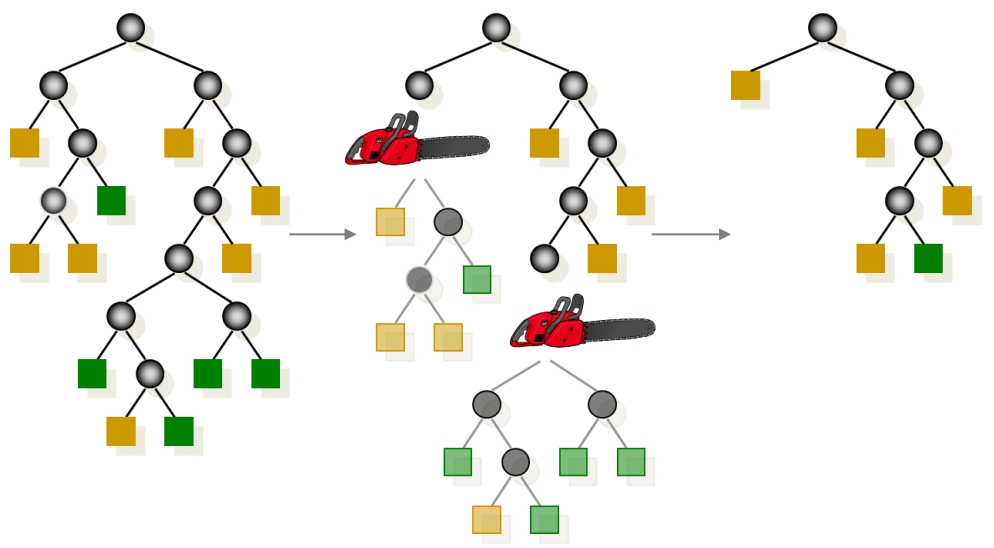

In [125]:
Image("decision tree.png")

DecisionTreeClassifier() class 인자 중    
> max_depth: 트리의 최대 깊이    
min_samples_split: 분할 되기 위해 노드가 가져야 하는 최소 샘플의 수        
min_samples_leaf: 리프 노드 (자식이 없는 노드)가 가지고 있어야할 최소 샘플 수    

를 조정해서 prunning이 가능합니다. 위 인자 중 max_dept 만을 이용해서 Tree 모델을 개선해보겠습니다.

In [132]:
# train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적  max_depth 구하기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
# max_depth 후보: [3,4,5,6,7]
# estimator = DecisionTreeClassifier()
# GridSearchCV scoring = 'accuracy'를 사용해주세요.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
max_depths = [3,4,5,6,7]
grid = {'max_depth': max_depths}

# estimator 선언
tree = DecisionTreeClassifier()

# hyper parameter tunning
gscv = GridSearchCV(tree, grid, scoring= 'accuracy', cv=cv, n_jobs=-1)
results = gscv.fit(X_train, y_train)
print(results.best_params_)

{'max_depth': 4}


In [134]:
# (3) 최종 KNN 모델 선언 및 학습
# 위에서 구한 best model을 사용합니다.
# knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
tree = results.best_estimator_

# (4) confusion matrix 출력 및 결과 해석
y_train_hat = tree.predict(X_train)
y_test_hat = tree.predict(X_test)

In [135]:
confusion_matrix(y_train, y_train_hat)

array([[364,  15],
       [ 85, 158]], dtype=int64)

In [137]:
confusion_matrix(y_test, y_test_hat)

array([[160,  10],
       [ 33,  64]], dtype=int64)

In [140]:
print('Train Data')
print('정확도: ', round(accuracy_score(y_train, y_train_hat),3))
print('재현율: ', round(recall_score(y_train, y_train_hat),3))
print('정밀도:', round(precision_score(y_train, y_train_hat),3))

Train Data
정확도:  0.839
재현율:  0.65
정밀도: 0.913


In [139]:
print('Test Data')
print('정확도: ', round(accuracy_score(y_test, y_test_hat),3))
print('재현율: ', round(recall_score(y_test, y_test_hat),3))
print('정밀도:', round(precision_score(y_test, y_test_hat),3))

Test Data
정확도:  0.839
재현율:  0.66
정밀도: 0.865


Generalization 성능이 개선된 것을 확인할 수 있습니다.

---

## Tree 기반 회귀

Tree 모델을 이용해서 회귀 문제도 해결이 가능합니다.   
본 실습에서는 간단하게 train-test split 만 사용하겠습니다.  

In [143]:
# Tree 기반 회귀 라이브러리는 다음과 같습니다.
from sklearn.tree import DecisionTreeRegressor

In [146]:
# boston_house 데이터에 간단하게 적용해보겠습니다.
df = pd.read_csv('./Boston_house.csv')
df.head()

,AGE,B,RM,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,ZN,TAX,CHAS,Target
0,65.2,396.90,6.575,0.00632,4.0900,2.31,4.98,0.538,15.3,1,18.0,296,0,24.0
1,78.9,396.90,6.421,0.02731,4.9671,7.07,9.14,0.469,17.8,2,0.0,242,0,21.6
2,61.1,392.83,7.185,0.02729,4.9671,7.07,4.03,0.469,17.8,2,0.0,242,0,34.7
3,45.8,394.63,6.998,0.03237,6.0622,2.18,2.94,0.458,18.7,3,0.0,222,0,33.4
4,54.2,396.90,7.147,0.06905,6.0622,2.18,5.33,0.458,18.7,3,0.0,222,0,36.2


In [147]:
# X, y 구분
X= df.iloc[:,:-1]
y = df.iloc[:,-1]

In [150]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [151]:
tree_reg = DecisionTreeRegressor(max_depth= 3)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [155]:
from sklearn.metrics import mean_squared_error

y_hat_tr = tree_reg.predict(X_train)
y_hat_te = tree_reg.predict(X_test)


print('Training data')
print('R^2: ', tree_reg.score(X_train, y_train))
print('MSE: ', mean_squared_error(y_train,y_hat_tr))
print()
print('Test data')
print('R^2: ', tree_reg.score(X_test, y_test))
print('MSE: ', mean_squared_error(y_test,y_hat_te))

Training data
R^2:  0.4609930943756426
MSE:  0.12583524447353103

Test data
R^2:  0.4671237662162583
MSE:  0.12873226582254765


---

## Making things easier....

SVM에 대해서도 동일한 
> Cross validation (교차 검증)과 GridSearch 를 활용한 모델 학습, 평가    

를 할 것이기 때문에 위 과정을 함수로 작성하겠습니다.

In [1]:
def my_cv_fit(model, 
             grid,
              X, y,
              test_size=0.3,
              n_splits= 10, n_repeats= 3,
              scoring = 'accuracy'
             ):
    # train_test split (test_size= 0.3)하고 train 데이터를 다시 train_validation으로 나눠서 최적  hyper-parameter 구하기
    # estimator = model
    # GridSearchCV scoring = 'accuracy'를 사용.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size)
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    # grid:
    # 함수 인자로 받음.
    # estimator 선언
    # model 함수 인자로 받음.

    # hyper parameter tunning
    gscv = GridSearchCV(model, grid, scoring= scoring, cv=cv, n_jobs=-1)
    results = gscv.fit(X_train, y_train)
    print(results.best_params_)
    
    # (3) 최종 KNN 모델 선언 및 학습
    # 위에서 구한 best model을 사용합니다.
    # knn = KNeighborsClassifier(n_neighbor=5) 또는 results.best_estimator_ 사용
    best_estimator = results.best_estimator_

    # (4) confusion matrix 출력 및 결과 해석
    y_train_hat = best_estimator.predict(X_train)
    y_test_hat = best_estimator.predict(X_test)
    
    
    print('Train Data')
    print('정확도: ', round(accuracy_score(y_train, y_train_hat),3))
    print('재현율: ', round(recall_score(y_train, y_train_hat),3))
    print('정밀도:', round(precision_score(y_train, y_train_hat),3))
    
    
    print('Test Data')
    print('정확도: ', round(accuracy_score(y_test, y_test_hat),3))
    print('재현율: ', round(recall_score(y_test, y_test_hat),3))
    print('정밀도:', round(precision_score(y_test, y_test_hat),3))

    return results

## Debugging

In [158]:
# 데이터 불러오기
data = titanic.copy()

# Embarked 의 'S' --> 1, 'C' --> 2, 'Q' --> 3 으로 '맵핑'함. 
# 값이 클수록 생존 확률이 클 (또는 작을) 것.
mapping = {'S':1, 'C':2, 'Q':3}  
mapping2 = {'male':1, 'female':0}

# pd.DataFrame.map(mapping)
data['Embarked'] = data['Embarked'].map(mapping)
data['Sex'] = data['Sex'].map(mapping2)

# 종속 변수, 독립 변수 나누기
X, y = data[data.columns.drop('Survived')], data[['Survived']]

In [159]:
tree = DecisionTreeClassifier()
grid = {'max_depth': [3,4,5,6]}
results = my_cv_fit(tree, grid, X, y)

{'max_depth': 4}
Train Data
정확도:  0.844
재현율:  0.719
정밀도: 0.845
Test Data
정확도:  0.82
재현율:  0.705
정밀도: 0.813


---

## LDA

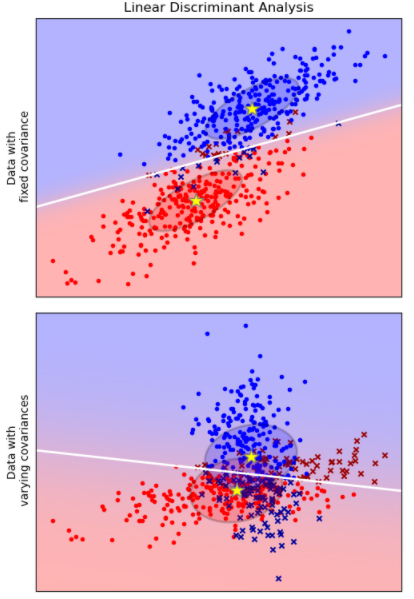

In [165]:
Image("lda.png")

### Mathmatical formulation of the LDA and QDA classifiers     
QDA와 LDA모두 class conditional distribution of data ($ P(X|y=k) $ for each class k) 를 이용합니다.   
Conditional probability 는 Bayes' rule을 사용해서 다음과 같이 구합니다.     
  
> 
\begin{align*}  
P(y=k|x) &= \frac{P(x|y=k)P(y=k)}{P(x)} \\ \\
&= \frac{P(x|y=k)P(y=k)}{\sum_{l} P(x|y=l)\times P(y=l)}
\end{align*}
   
위 공식을 이용해서 구한 확률을 최대로 하는 class $k$ 를 예측값으로 합니다.   
이 때 LDA와 QDA 모두 
> (1) $P(X|y)$는 Multivaraite Gaussian distribution으로 가정하며, 이 분포에서 모든 클래스 별 데이터의 분산이 같다고 가정하면 LDA이고 아니라면 QDA 알고리즘을 사용하게 됩니다.   
(2) $P(y=l)$는 class proportion으로서 추론됩니다.   


자세한 수식은 강의 자료를 참고하시길 부탁드립니다.   
 * 특별히 조정할 hyper-parameter는 없기 때문에 패키지 사용법을 간단히 짚고 넘어가는 형식으로 하겠습니다.

In [167]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [168]:
# 사용법은 다음과 같습니다. 

# 모델 선언
lda = LinearDiscriminantAnalysis()

In [169]:
# 모델 학습
lda.fit(X,y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LinearDiscriminantAnalysis()

In [170]:
# 모델 예측
y_hat = lda.predict(X)

In [172]:
confusion_matrix(y, y_hat)

array([[474,  75],
       [104, 236]], dtype=int64)

In [174]:
# 확률값 예측
y_hat_prob = lda.predict_proba(X)

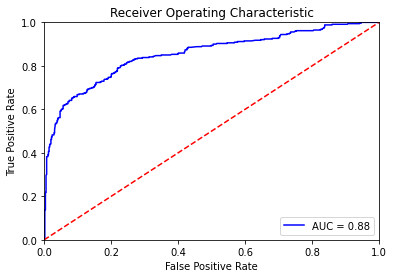

In [176]:
fpr, tpr, threshold = metrics.roc_curve(y, y_hat_prob[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## QDA

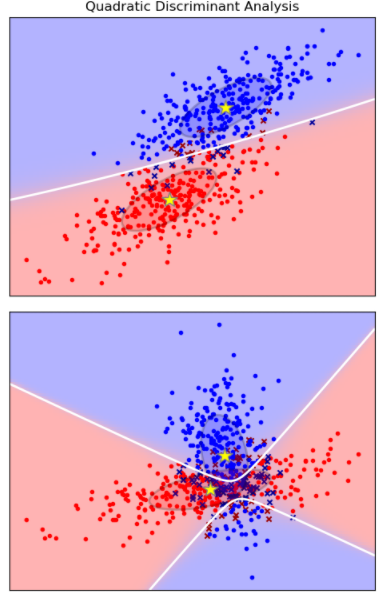

In [188]:
Image("qda.png")

In [163]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [178]:
# 사용법은 다음과 같습니다. 

# 모델 선언
qda = QuadraticDiscriminantAnalysis()

In [179]:
# 모델 학습
qda.fit(X,y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


QuadraticDiscriminantAnalysis()

In [180]:
# 모델 예측
y_hat = qda.predict(X)

In [182]:
# 모델 평가
confusion_matrix(y, y_hat)

array([[483,  66],
       [105, 235]], dtype=int64)

In [184]:
# 확률값 예측
y_hat_prob = lda.predict_proba(X)

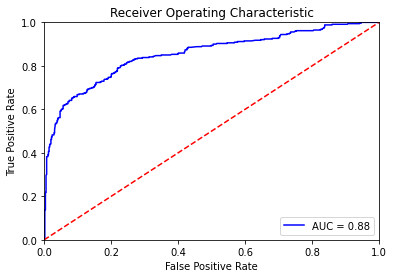

In [185]:
fpr, tpr, threshold = metrics.roc_curve(y, y_hat_prob[:,1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM

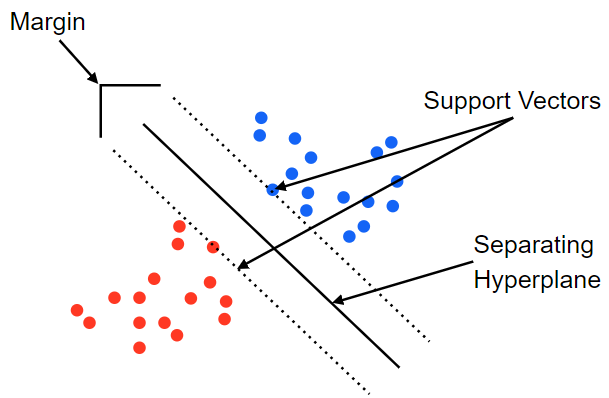

In [187]:
Image('./svm.png')

SVM은 Margin을 최대화 하는 Hyperplane (decision boundary)를 찾는 알고리즘입니다.    
본 챕터에서는 SVM을 파이썬 라이브러리를 사용해서 실습해보겠습니다.

SVM의 주요 Hyper parmeter는 다음과 같습니다.     
> C: Regularization parameter - 오분류를 어느 정도로 허용할 지 결정하는 파라미터.               
kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

In [189]:
from sklearn.svm import SVC # Support Vector Machine Classifier.

Cross validation 과 Grid search 없이, 간단하게 Linear SVM을 학습한 후 attribute 에 친숙해져 보겠습니다.

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3)

In [204]:
# 모형 선언 후 학습
lin_svc = SVC(kernel='linear')  # default C=1.0
lin_svc.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(kernel='linear')

In [205]:
# 각 클래스의 서포트 벡터 개수
lin_svc.n_support_

array([137, 138])

In [206]:
# 서포트 벡터에 해당하는 관측치 인덱스
lin_svc.support_

array([  4,   5,  15,  21,  28,  34,  42,  43,  44,  61,  62,  73,  76,
        77,  82,  84,  89,  91,  98, 101, 103, 108, 113, 118, 120, 122,
       125, 130, 133, 135, 139, 142, 144, 148, 150, 160, 166, 167, 171,
       175, 178, 180, 194, 204, 218, 220, 231, 232, 236, 247, 251, 256,
       258, 260, 264, 266, 272, 279, 283, 291, 295, 298, 309, 311, 312,
       316, 319, 321, 326, 329, 331, 340, 342, 350, 355, 357, 359, 360,
       361, 364, 373, 374, 384, 388, 390, 397, 399, 403, 405, 407, 409,
       414, 416, 417, 418, 420, 425, 430, 447, 449, 450, 453, 454, 458,
       463, 470, 475, 482, 484, 488, 491, 496, 498, 501, 505, 507, 514,
       524, 527, 534, 544, 546, 552, 566, 567, 568, 569, 570, 574, 586,
       590, 591, 592, 600, 605, 610, 621,   7,  10,  12,  18,  23,  24,
        26,  27,  31,  38,  46,  52,  55,  56,  58,  65,  66,  70,  83,
        87,  88,  92,  93,  96, 100, 102, 104, 112, 114, 115, 126, 129,
       134, 136, 141, 143, 145, 146, 154, 158, 164, 168, 170, 17

In [207]:
# Support vector 5 개만 프린트
lin_svc.support_vectors_[:5,:]

array([[ 3.    ,  0.    , 45.    ,  0.    ,  1.    , 14.4542,  2.    ],
       [ 2.    ,  1.    , 23.    ,  0.    ,  0.    , 13.    ,  1.    ],
       [ 3.    ,  1.    , 19.    ,  0.    ,  0.    ,  6.75  ,  3.    ],
       [ 3.    ,  0.    , 26.    ,  1.    ,  0.    , 16.1   ,  1.    ],
       [ 2.    ,  1.    , 30.    ,  0.    ,  0.    , 13.    ,  1.    ]])

In [208]:
# 서포트 벡터에 해당하는 관측치 값
pd.DataFrame(lin_svc.support_vectors_, 
             columns=X.columns).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3.0,0.0,45.0,0.0,1.0,14.4542,2.0
1,2.0,1.0,23.0,0.0,0.0,13.0000,1.0
2,3.0,1.0,19.0,0.0,0.0,6.7500,3.0
3,3.0,0.0,26.0,1.0,0.0,16.1000,1.0
4,2.0,1.0,30.0,0.0,0.0,13.0000,1.0


In [209]:
# weights and intercept
print(lin_svc.coef_)
print(lin_svc.intercept_)

[[-0.13665486 -2.04478468 -0.01065298 -0.23604375 -0.12231002  0.00351971
   0.04985023]]
[1.56958113]


In [213]:
# 모델 예측
y_pred = lin_svc.predict(X_test)

In [214]:
# 예측된 label (5개 만 프린트)
y_pred[:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [220]:
# Confusion matrix
accuracy_score(y_train, lin_svc.predict(X_train))

0.792604501607717

In [221]:
accuracy_score(y_test, y_pred)

0.7940074906367042

#### 이제 최적 kernel 과 regularization parameter C를 찾아서 모델링해보겠습니다.

In [202]:
# 사용할 모델
model = SVC()

# Regularization parmeter 후보
# C: Regularization parameter - 오분류를 어느 정도로 허용할 지 결정하는 파라미터. default= 1.
# kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
grid = {
    'C':[1,5,10,100],
    'kernel':['linear','rbf']
}

# 이 전에 작성한 함수를 사용하도록 하겠습니다.
results = my_cv_fit(model, grid, X. y, n_splits= 5, n_repeats= 1)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'C': 100, 'kernel': 'linear'}
Train Data
정확도:  0.807
재현율:  0.694
정밀도: 0.767
Test Data
정확도:  0.764
재현율:  0.648
정밀도: 0.737
